<a href="https://colab.research.google.com/github/manmclir/GNN_CRA/blob/main/Copy_of_GNN_CRA_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html


In [4]:
import torch
import torch_scatter
import torch_sparse
import torch_geometric
import tqdm.auto
import os
from operator import itemgetter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import re
import math

import csv

In [5]:

### A simple Message-Passing network w/ common aggregation schemes.
class Simple_GNN(torch.nn.Module):

    def __init__(self,in_features,int_features,out_features,depth,aggregation_mode = 'mean',dropout_prob = .1):
        '''
        [in_features]       - # of input features.
        [int_features]      - # of features in message-passing layers. Within the 
                              GNN literature, this is typically a constant.
        [out_features]      - # of output features. Corresponds to # of classes,
                              regression targets, etc.
        [depth]             - # of message-passing layers. 
        [aggregation_mode]  - choice of aggregation scheme. Can be 'mean',
                              'sum', 'max', or 'none'
        [dropout_prob]      - probability used for Dropout (see Srivastava et al., 2017)
        '''

        super(Simple_GNN,self).__init__()
        assert aggregation_mode in ['mean','sum','max','none']

        self.f_in = torch.nn.Linear(in_features,int_features)
        self.f_int = torch.nn.ModuleList([torch.nn.Sequential(*[torch.nn.Linear(int_features,int_features),
                                                                torch.nn.LeakyReLU(),
                                                                torch.nn.Dropout(dropout_prob)])
                                              for _ in range(depth)])
        self.f_out = torch.nn.Linear(int_features,out_features)

        if aggregation_mode == 'mean': self.agg = torch_scatter.scatter_mean
        elif aggregation_mode == 'sum': self.agg = torch_scatter.scatter_sum
        elif aggregation_mode == 'max': self.agg = torch_scatter.scatter_max

        self.aggregation_mode = aggregation_mode

    def forward(self,node_features,edge_index,edge_weights = None):
        '''
        [node_features]  - Matrix of node features. First (batch) dimension corresponds
                           to nodes; second to features.
        [edge_index]     - Edge list representation of a graph. Shape [num_edges]x2
        [edge_weights]   - Optional scalar edge weights. Shape [num_edges,1]
        '''

        node_features = self.f_in(node_features)
        for idx,layer in enumerate(self.f_int):
            if self.aggregation_mode is not 'none':
                if edge_weights is not None:
                    aggregated_node_features = self.agg(edge_weights * node_features[edge_index[:,0]],
                                                                    edge_index[:,1],dim=0)
                else:
                    aggregated_node_features = self.agg(node_features[edge_index[:,0]],edge_index[:,1],dim=0) 
            else:
                aggregated_node_features = node_features
                
            if isinstance(aggregated_node_features,tuple): 
                aggregated_node_features = aggregated_node_features[0]

            node_features = node_features + layer(aggregated_node_features)
        return self.f_out(node_features),node_features

In [6]:
### General purpose object for storing graph data
class Graph(object):
    def __init__(self,edge_index = None,edge_metadata = None,node_metadata = None):
        self.edge_index = edge_index
        self.edge_metadata = edge_metadata
        self.node_metadata = node_metadata
        self.num_nodes = None

    def read_edges(self,filepath):
        ''' Edges should be stored as follows:
            0 1 3.1 2.0
            0 2 1.0 0.0
            1 0 3.1 2.0
            ...
        where the first two columns are node indices and the remainder
        are edge features. '''

        with open(filepath,'r') as f:
          edges = torch.Tensor([list(map(float,line.strip().split(' '))) \
                                         for line in f.readlines()])
        if edges.shape[1] == 2:
          self.edge_index = edges.long()
        elif edges.shape[1] >= 3:
          self.edge_index = edges[:,:2].long()
          self.edge_metadata = edges[:,2::]
                      
    def read_node_metadata(self,filepath,padding_value = 0.0):
        ''' Nodes should be stored as follows:
            0 4.1 9.2 1.1 ...
            2 3.3 1.1 9.0 ...
            ...
        where the first column is the node index and the remainder
        are node features. If a node is not listed but should still 
        clearly exist (e.g, nodes '0' and '2' are present in the file
        but not node '1'), the missing node is given constant features 
        set to [padding_value]'''

        with open(filepath,'r') as f:
          nodes = torch.Tensor([list(map(float,line.strip().split(' '))) \
                                         for line in f.readlines()])
          
        self.num_nodes = 1 + nodes[:,0].max().long()
        node_metadata = padding_value * torch.ones((self.num_nodes,nodes.shape[1]-1))
        node_metadata[nodes[:,0].long()] = nodes[:,1::]   #GE

        self.node_metadata = node_metadata

In [7]:
### Dataset consisting of multiple _Graph_ objects
class GraphsDataset(object):
    ''' Graph metadata is expected to be saved 
        under [graph_dir]/[...]/edges.txt and
        [graph_dir]/[...]/nodes.txt.
    ******* Optional Arguments *********
    [add_self_loops] - Add self loop to each graph. 
                       This tends to improve importance,
                       and it resolves issues with 
                       disconnected nodes.
    '''
    def __init__(self,graph_dir,add_self_loops = True):
        self.root = graph_dir
        self.graphs = os.listdir(graph_dir)
        self.add_self_loops = add_self_loops
    def __len__(self):
        return len(self.graphs)
    def __getitem__(self,idx):
        G = Graph()
        G.read_edges(self.root + '/' + self.graphs[idx]+'/edges.txt')
        G.read_node_metadata(self.root + '/' + self.graphs[idx]+'/nodes.txt')

        if self.add_self_loops:
            self_loops = torch.cat((torch.arange(G.num_nodes)[:,None],torch.arange(G.num_nodes)[:,None]),dim=-1)
            G.edge_index = torch.cat((G.edge_index,self_loops),dim=0)
            G.edge_metadata = torch.cat((G.edge_metadata,torch.ones((G.num_nodes,1))),dim=0)
        return G 

### Helper function to construct batches of graphs. We assume the user wants to
### perform graph-level tasks, and so our target variable is chosen as
### G.node_metadata[0,0] i.e, the first feature of the first node.
def collate_fn(data):
    c,n = 0,0
    for idx,G in enumerate(data):
        if idx == 0: 
            X,Y = G.node_metadata[:,1::],G.node_metadata[0,0][None]
            edge_index,edge_weights = G.edge_index,G.edge_metadata
            batch_index = c * torch.ones(G.num_nodes)
        else:
            X = torch.cat((X,G.node_metadata[:,1::]),dim=0)
            Y = torch.cat((Y,G.node_metadata[0,0][None]),dim=0)

            edge_index = torch.cat((edge_index,n + G.edge_index),dim=0)
            edge_weights = torch.cat((edge_weights,G.edge_metadata),dim=0)
            batch_index = torch.cat((batch_index,c * torch.ones(G.num_nodes)),dim=0)
        n += G.num_nodes
        c += 1

    return {'X':X,'edge_index':edge_index,'edge_weights':edge_weights,'Y':Y.long(),'batch_index':batch_index.long()}

In [8]:
### Call to fit node-level model and save results
class GNN_Node_Trainer(object):
    def __init__(self,graph,**kwargs):
        '''
        [graph]  - Instance of _Graph_. Expects to be fully initialized. 
        ******* Optional Arguments *********
        [train_index],[test_index] - Partitions graph into train and test sets.
                                     Defaults to random 60%/40% split.
        [num_epochs]               - # of epochs to train. Defaults to 20.
        [loss_func]                - Loss function to minimize. Defaults to 
                                     Cross Entropy.
        [random_seed]              - Defaults to 0. 
        '''
        torch.manual_seed(kwargs.get('random_seed',0))

        assert isinstance(graph,Graph)        
        self.graph = graph

        ### If train_index and test_index are not provided, we randomly
        ### select a train/test split.
        r = torch.randperm(graph.num_nodes)
        self.train_index,self.test_index = kwargs.get('train_index',r[:int(.6 * len(r))]),\
                                  kwargs.get('test_index',r[int(.6 * len(r))::])

        self.num_epochs = kwargs.get('num_epochs',20)
        self.loss_func = kwargs.get('loss_func',lambda x,y,*args: torch.nn.functional.cross_entropy(x,y.long()))

    def __call__(self,model,**kwargs):
        '''
        [model]  - i.e, our GNN 
        ******* Optional Arguments *********
        [lr],[beta],['weight_decay'] - Optimizer parameters. Default to 1e-3, (.9,.999), 
                                       and 1e-2.
        [quiet]                      - Boolean. Disables logging to stdout
        [metrics_callback]           - Dict of functions to compute additional metrics.
        [title]                      - Saves metrics and model ckpt to 'gnn_results/[title]'
                                       at end of training. Defaults to 'run_0'.
        [device]                     - Should be 'cpu' or 'cuda:0'. Defaults to 'cpu'.

        Note: We assume the first column of 'self.graph.node_metedata' to be our 
        target values.
        '''
        opt = torch.optim.Adam(model.parameters(),lr=kwargs.get('lr',1e-3),
                                        betas = kwargs.get('beta',(0.9, 0.999)),
                                        weight_decay=kwargs.get('weight_decay',1e-2)
                                )

        device = torch.device(kwargs.get('device','cpu'))
        model.to(device)

        ### Load data to device.
        node_features,edge_index,edge_weights = self.graph.node_metadata.to(device),\
                                                    self.graph.edge_index.to(device),\
                                                    self.graph.edge_metadata.to(device)
        X,Y = node_features[:,1::].to(device),node_features[:,0].to(device)

        metrics = {'train_loss':[],'test_loss':[]}
        metrics_callback = kwargs.get('metrics_callback',{})
        for key in metrics_callback.keys(): 
            metrics['train_'+key] = []
            metrics['test_'+key] = []

        pbar = tqdm.tqdm(range(self.num_epochs),position=0,disable=kwargs.get('quiet',False))
        for idx in pbar:
            ### Get predictions and compute losses over train and test sets.
            predictions,_ = model(X,edge_index,edge_weights)
            train_loss,test_loss = self.loss_func(predictions[self.train_index],Y[self.train_index],
                                                  edge_index,edge_weights),\
                                          self.loss_func(predictions[self.test_index],Y[self.test_index],
                                                  edge_index,edge_weights)

            pbar.set_description(f'Train Loss: {train_loss.item():.3f}\tTest Loss: {test_loss.item():.3f}')
            if torch.isnan(train_loss): raise ValueError('Training loss is NaN')

            ### Backpropagate w.r.t training loss
            train_loss.backward()
            opt.step()
            opt.zero_grad()

            ### Save losses and compute additional metrics
            metrics['train_loss'].append(train_loss.item())
            metrics['test_loss'].append(test_loss.item())
            for key in metrics_callback.keys():
                metrics['train_'+key].append(metrics_callback[key](predictions[self.train_index],Y[self.train_index],
                                                        edge_index,edge_weights))
                metrics['test_'+key].append(metrics_callback[key](predictions[self.test_index],Y[self.test_index],
                                                        edge_index,edge_weights))

        os.makedirs('gnn_results',exist_ok=True)
        title = kwargs.get('title','run_0')
        os.makedirs('gnn_results/{}'.format(title),exist_ok=True)
        torch.save(model.state_dict(),'gnn_results/{}/ckpt'.format(title))
        torch.save(metrics,'gnn_results/{}/metrics'.format(title))

        return predictions

In [9]:
### Call to fit graph-level model and save results
class GNN_Graph_Trainer(object):
    def __init__(self,graphs,collate_fn,**kwargs):
        '''
        [graphs]      - Instance of _GraphsDataset_. Expects to be fully initialized. 
        [collate_fn]  - Collate function for batching purposes.
        ******* Optional Arguments *********
        [batch_size]               - Number of graphs per train/val batch. Defaults
                                     to 50.
        [train_%]                  - Pct. split into train set. Defaults to 80%/20%.
        [num_epochs]               - # of epochs to train. Defaults to 20.
        [loss_func]                - Loss function to minimize. Defaults to 
                                     Cross Entropy. 
        [random_seed]              - Defaults to 0.
        '''
        torch.manual_seed(kwargs.get('random_seed',0))

        assert isinstance(graphs,GraphsDataset)
        self.graphs = graphs
        self.collate_fn = collate_fn

        self.train_pct = kwargs.get('train_%',.8)

        self.batch_size = kwargs.get('batch_size',50)
        self.num_epochs = kwargs.get('num_epochs',20)
        self.loss_func = kwargs.get('loss_func',lambda x,y,*args: torch.nn.functional.cross_entropy(x,y.long()))

    def __call__(self,model,**kwargs):
        '''
        [model]  - i.e, our GNN 
        ******* Optional Arguments *********
        [lr],[beta],['weight_decay'] - Optimizer parameters. Default to 1e-3, (.9,.999), 
                                       and 1e-2.
        [quiet]                      - Boolean. Disables logging to stdout
        [metrics_callback]           - Dict of functions to compute additional metrics.
        [title]                      - Saves metrics and model ckpt to 'gnn_results/[title]'
                                       at end of training. Defaults to 'run_0'.
        [device]                     - Should be 'cpu' or 'cuda:0'. Defaults to 'cpu'.

        Note: We assume 'self.graphs[idx].node_metedata[0,0]' 
        to be our target value for all idx \in [0,len(self.graphs)] .
        '''
        opt = torch.optim.Adam(model.parameters(),lr=kwargs.get('lr',1e-3),
                                        betas = kwargs.get('beta',(0.9, 0.999)),
                                        weight_decay=kwargs.get('weight_decay',1e-2)
                                )

        device = torch.device(kwargs.get('device','cpu'))
        model.to(device)
        
        ### Generate train/test split.
        train,test = torch.utils.data.random_split(self.graphs,[int(len(self.graphs) * self.train_pct),
                                                               len(self.graphs) - int(len(self.graphs) * self.train_pct)]
                                                  )
        train_loader,test_loader = torch.utils.data.DataLoader(train,batch_size=self.batch_size,shuffle=True,collate_fn=self.collate_fn),\
                              torch.utils.data.DataLoader(test,batch_size=self.batch_size,shuffle=True,collate_fn=self.collate_fn)

        metrics = {'train_loss':[],'test_loss':[]}
        metrics_callback = kwargs.get('metrics_callback',{})
        for key in metrics_callback.keys(): 
            metrics['train_'+key] = []
            metrics['test_'+key] = []

        pbar = tqdm.tqdm(range(self.num_epochs),position=0,disable=kwargs.get('quiet',False))
        for idx in pbar:

            ### Training loop
            model.train()
            for data in train_loader:
                X,Y,edge_index,edge_weights,batch_index = data['X'].to(device),data['Y'].to(device),data['edge_index'].to(device),\
                                                              data['edge_weights'].to(device),data['batch_index'].to(device)

                predictions,_ = model(X,edge_index,edge_weights)
                ### To keep things simple, we employ mean READOUT to produce a global
                ### graph embedding. 
                train_loss = self.loss_func(torch_scatter.scatter_mean(predictions,batch_index,dim=0),Y,edge_index,edge_weights)

                pbar.set_description(f'Train Loss: {train_loss.item():.3f}')
                if torch.isnan(train_loss): raise ValueError('Training loss is NaN')

                train_loss.backward()
                opt.step()
                opt.zero_grad()

                ### Compute and save metrics.
                metrics['train_loss'].append(train_loss.item())
                for key in metrics_callback.keys():
                        metrics['train_'+key].append(metrics_callback[key](torch_scatter.scatter_mean(predictions,batch_index,dim=0),
                                                                    Y,edge_index,edge_weights))
                        
            ### Evaluation loop. 
            model.eval()
            with torch.no_grad():
                for data in test_loader:
                    X,Y,edge_index,edge_weights,batch_index = data['X'].to(device),data['Y'].to(device),data['edge_index'].to(device),\
                                                              data['edge_weights'].to(device),data['batch_index'].to(device)

                    predictions,_ = model(X,edge_index,edge_weights)
                    train_loss = self.loss_func(torch_scatter.scatter_mean(predictions,batch_index,dim=0),Y,edge_index,edge_weights)

                    pbar.set_description(f'Test Loss: {train_loss.item():.3f}')

                    metrics['test_loss'].append(train_loss.item())
                    for key in metrics_callback.keys():
                          metrics['test_'+key].append(metrics_callback[key](torch_scatter.scatter_mean(predictions,batch_index,dim=0),
                                                                    Y,edge_index,edge_weights))

        os.makedirs('gnn_results',exist_ok=True)
        title = kwargs.get('title','run_0')
        os.makedirs('gnn_results/{}'.format(title),exist_ok=True)
        torch.save(model.state_dict(),'gnn_results/{}/ckpt'.format(title))
        torch.save(metrics,'gnn_results/{}/metrics'.format(title))

        return predictions

In [10]:
path = "/content/drive/MyDrive/output7_new_sentiment.csv"
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
emails = pd.read_csv(path)
#loads the emails into a pandas dataframe

In [12]:
emails_2011_08 = emails.iloc[0:2]
#this creates a small subsection of the emails that were sent in 2011/08 for testing

In [13]:
def get_Unique_Nodes(df):
  #this takes in a pandas dataframe
  
  to_list = []
  from_list = []
  CC_list = []

  alist = df['To']
#this gets all of the values under To for the df 

  for x in alist:# this interates through the values for To and
    result = re.findall('\(.*?\)', x)#appends all of the values in it that are contained in ()
    for s in result:
            to_list.append(s)


  blist = df['From']#the same that is done for To is done for From  and CC

  for x in blist:
    result = re.findall('\(.*?\)', x)
    for s in result:
            from_list.append(s)


  clist = df['CC']

  for x in clist:
    result = re.findall('\(.*?\)', x)
    for s in result:
            CC_list.append(s)

  final_list = to_list + from_list #+ CC_list #The lists are combined together

  Myfinallist = sorted(set(final_list)) #this takes out any repeating values

  return Myfinallist #returns a list of str


In [14]:
nodes_2011_08 = get_Unique_Nodes(emails_2011_08)
all_nodes = get_Unique_Nodes(emails)
#generates the nodes that were used in 2011/08 and all of the nodes in the dataset

In [15]:
def make_edgelist(df, nodes):
  #takes in a dataframe and a list of str
  #df is supposed to be the email dataset and nodes is the nodes generated from the dataset
  edgelist = set()
  #creates a set so that there are only unique edges
  #maybe in the future it can account for multiple edges
  
  for node in nodes:
    #it goes through the nodes and gets all of the emails that were sent from that node
    if node != '':
      from_who = df.loc[df['From'] == node]
      r = len(from_who.index)

      for i in range(r):
        #iterates through all of the emails that were sent from a particular node
        #and saves all of the values encased in () and appends it to the edge list
        j = from_who.iloc[i:i+1]
        x = j['To']
        #y = j['CC']
        index_1 = nodes.index(node)
        for xi in x:
          #goes through the values in To and adds it to the edge list 
          if xi != '':
            result = re.findall('\(.*?\)', xi)
            for s in result:
              index_2 = nodes.index(s)
              edgelist.add(tuple([index_1, index_2]))
        '''
        for yi in y:
          #this is done for CC as well as From
          if yi != '':
            result = re.findall('\(.*?\)', yi)
            for s in result:
              index_2 = nodes.index(s)
              edgelist.add(tuple([index_1, index_2]))
        '''
  #this returns an edge list where the index is formatted [sender, reciever]
  return list(edgelist)

In [16]:
edge_2011_08 = make_edgelist(emails_2011_08, nodes_2011_08)
#generates an edgelist based on the nodes generated on the emails_2011_08 df

In [17]:
make_edgelist(emails,all_nodes)
#still has a problem generating an edge list for the entire graph
#don't know the specific problem yet
#eventually will find it as the rest of the email data set gets run through to create graphs

[(27827, 13266),
 (832, 29685),
 (2413, 15001),
 (22745, 5895),
 (1531, 9671),
 (30214, 30836),
 (30911, 2203),
 (3087, 20551),
 (30713, 11220),
 (1285, 23931),
 (22744, 25441),
 (23548, 8807),
 (1755, 14755),
 (23056, 21324),
 (30911, 5067),
 (4183, 13354),
 (1285, 31147),
 (23234, 201),
 (16700, 13130),
 (24853, 13825),
 (27383, 30806),
 (28729, 2616),
 (14589, 661),
 (287, 15354),
 (22843, 28883),
 (30911, 5484),
 (4118, 29156),
 (3283, 3106),
 (27469, 29244),
 (23592, 29373),
 (4143, 29156),
 (26584, 29514),
 (27136, 30625),
 (24616, 142),
 (30296, 20563),
 (3087, 17101),
 (29476, 19),
 (30129, 2059),
 (29952, 28973),
 (25268, 926),
 (29401, 29401),
 (2382, 31046),
 (25510, 24610),
 (3984, 12058),
 (2230, 22502),
 (23007, 16928),
 (27827, 7902),
 (3984, 23206),
 (30713, 10256),
 (4143, 25442),
 (28630, 9174),
 (30713, 11949),
 (1285, 30831),
 (30498, 25347),
 (26959, 27026),
 (30370, 29156),
 (25913, 3594),
 (405, 30836),
 (28872, 19074),
 (29391, 887),
 (25983, 1892),
 (661, 10012

In [18]:
def sep_by_year(df):
  #this takes in a dataframe and seperates it by the year the emails were sent
  time = df['Sent'].tolist()
  year_list = []
  initial_i = 0
  currentyear = int((time[0])[0:4])
  #this is the specific index for Sent to get the year
  end = len(df)
  for i in range(end):
    #this iterates through the emails in the df and if the year increases it 
    #splits the dataset and appends it to the year_list variable
    s = time[i]
    x = int(s[0:4])
    
    if x > currentyear:
      year_span = df.iloc[initial_i:i]
      year_list.append(year_span)
      initial_i = i
      currentyear = x
  year_list.append(df.iloc[initial_i:end])
  if len(year_list) == 1:#if the year got bigger then it just returns the same df as before
    return df
  return year_list

In [19]:

years = sep_by_year(emails)

In [20]:
def sep_by_month(df):
  #takes the same steps as sep_by_year except the index values have changed 
  #so that it retrieves the months instead of years
  time = df['Sent'].tolist()
  month_list = []
  initial_i = 0
  currentmonth = int((time[0])[5:7])
  end = len(df)
  for i in range(end):
    
    s = time[i]
    x = int(s[5:7])

    if x > currentmonth:
      month_span = df.iloc[initial_i:i]
      month_list.append(month_span)
      initial_i = i
      currentmonth = x
  month_list.append(df.iloc[initial_i:end])
  if len(month_list) == 1:
    return df
  return month_list

In [21]:
month_2012 = sep_by_month(years[1])

In [22]:
def sep_by_day(df):
  #takes the same steps as sep_by_year except the index values have changed 
  #so that it retrieves the days instead of years
  time = df['Sent'].tolist()
  day_list = []
  initial_i = 0
  currentday = int((time[0])[8:10])
  end = len(df)
  for i in range(end):
    
    s = time[i]
    x = int(s[8:10])

    if x > currentday:
      day_span = df.iloc[initial_i:i]
      day_list.append(day_span)
      initial_i = i
      currentday = x
  day_list.append(df.iloc[initial_i:end])
  if len(day_list) == 1:
    return df
  return day_list

In [23]:
sep_by_day(month_2012[0])

[   Unnamed: 0  ...                                   GCP_sentiment
 2           2  ...  [0.0, 2.799999952316284, 0.009523809361620015]
 
 [1 rows x 13 columns],
    Unnamed: 0  ...                                      GCP_sentiment
 3           3  ...  [0.20000000298023224, 2.799999952316284, 0.010...
 
 [1 rows x 13 columns]]

In [24]:
def disp_Graph(nodes, edges, title):
  #this displays the graph based on the nodes and edges
  G = nx.DiGraph()
  r = []
  labeldict = {}
  for i in range(len(nodes)):
    r.append(i)
    labeldict[i] = nodes[i]
  G.add_nodes_from(r)
  G.add_edges_from(edges)
  plt.figure()
  plt.title(title)
  nx.draw(G,labels=labeldict, with_labels=True)
  plt.show()

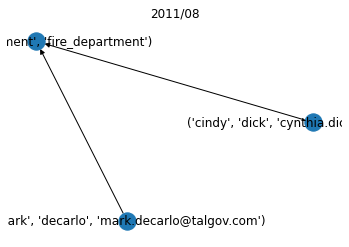

[(0, 1), (2, 1)]

In [25]:
disp_Graph(nodes_2011_08, edge_2011_08, '2011/08')
display(edge_2011_08)
#displays the graph based on the first month of the dataset

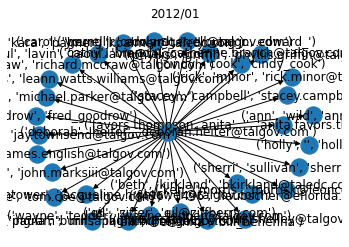

In [26]:
nodes_2012_01 = get_Unique_Nodes(month_2012[0])
edges_2012_01 = make_edgelist(month_2012[0], nodes_2012_01)


disp_Graph(nodes_2012_01,edges_2012_01, '2012/01')

#this displays the emails in the second month of the dataset
#though as can be seen here the graph gets very messy when too many nodes are added

In [27]:
display(len(nodes_2012_01))

32

In [28]:
#this is to test out different ways of concating dfs
all_2012 = pd.DataFrame()
for i in range(12):
  all_2012 = all_2012.append(month_2012[i])
display(len(all_2012))

1608

In [29]:
nodes_2012 = get_Unique_Nodes(all_2012)
edges_2012 = make_edgelist(all_2012, nodes_2012)

In [30]:
x = edges_2012[0]
display(len(x))

2

In [31]:
def create_edges_txt(edges):
  #creates a txt file that is just the edge list
  with open('edges.txt','w') as f:
    for edge in edges:
      f.write(f'{edge[0]} {edge[1]} {1}\n')
      #print(edge[0])

In [32]:
create_edges_txt(edges_2012)

In [33]:
def create_nodes_txt(nodes):#this one is more basic might delete in the future
  torch.manual_seed(0)
  with open('nodes.txt','w') as f:
    for node in nodes:
      X_str = ' '.join([str(element.item()) for element in .5 + torch.randn((16))])
      #display(X_str)
      #f.write(f'{nodes.index(node)}' + X_str + '\n')
      f.write(f'{nodes.index(node)} {nodes.index(node)} ' + X_str +'\n')

In [34]:
create_nodes_txt(nodes_2012)

In [35]:
all_2012_graph = Graph()
all_2012_graph.read_edges('edges.txt')
all_2012_graph.read_node_metadata('nodes.txt')

In [36]:
model = Simple_GNN(16,64,8133,3,aggregation_mode='mean')

display((all_2012_graph.node_metadata).shape)

### We initialize the GNN_Trainer and train for 200
### epochs on CPU. 
trainer = GNN_Node_Trainer(all_2012_graph,num_epochs=200,random_seed=1)
#display(model)
predictions = trainer(model)

torch.Size([5958, 17])

Train Loss: 3.944	Test Loss: 15.338: 100%|██████████| 200/200 [02:50<00:00,  1.17it/s]


In [37]:
def get_sent_list(edges, l):
  e_length = len(edges)
  sent_list = np.zeros(l)
  for i in range(e_length):
    x = list(edges[i])
    y = x[0]
    sent_list[y] = sent_list[y] + 1

  return sent_list


In [38]:
display(edge_2011_08)
get_sent_list(edge_2011_08, len(nodes_2011_08))
sent_2012 = get_sent_list(edges_2012, len(nodes_2012))

[(0, 1), (2, 1)]

In [39]:
def get_recieved_list(edges, l):
  e_length = len(edges)
  recieved_list = np.zeros(l)
  for i in range(e_length):
    x = list(edges[i])
    y = x[1]
    recieved_list[y] = recieved_list[y] + 1

  return recieved_list

In [40]:
recieved_2012 = get_recieved_list(edges_2012, len(nodes_2012))

In [41]:
def create_nodes_txt(nodes):
  #takes a list that has the node list, the sent list, and the recieved list
  #this is a new version of create_nodes_txt that incorporates the node metadata
  torch.manual_seed(0)
  with open('nodes.txt','w') as f:
    for i in range(len(nodes[0])):
      #display(node)
      X_str = ' '.join([str(element.item()) for element in .5 + torch.randn((16))])
      s = ''
      for n in range(len(nodes)):
        s = s + str(nodes[n][i]) + ' '
      #f.write( str(nodes[0][i]) + ' ' + s + X_str +'\n')
      f.write( str(nodes[0][i]) + ' ' + s +'\n')

In [42]:
node_num_2012 = []
for node in nodes_2012:
  x = nodes_2012.index(node)
  node_num_2012.append(x)
node_meta_2012 = [node_num_2012, sent_2012, recieved_2012]
display(len(node_meta_2012))
create_nodes_txt(node_meta_2012)

3

In [43]:
all_2012_graph = Graph()
all_2012_graph.read_edges('edges.txt')
all_2012_graph.read_node_metadata('nodes.txt')

In [44]:
model = Simple_GNN(2,64,5958,3,aggregation_mode='mean')

display((all_2012_graph.node_metadata).shape)

### We initialize the GNN_Trainer and train for 200
### epochs on CPU. 
trainer = GNN_Node_Trainer(all_2012_graph,num_epochs=200,random_seed=1)
#display(model)
predictions = trainer(model)

torch.Size([5958, 3])

Train Loss: 7.236	Test Loss: 12.630: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


In [46]:

def get_email_node_meta(df):
  body = df['Body']
  body_list = []
  char_count = []
  word_count = []
  mean_char_word = []
  std_char_word = []

  for x in body:# this interates through the values for To and
    result = re.findall('\'.*?\'', x)#creates a list of all of the values in x that are contained in ''
    q = ' '.join(result)#this makes everything into one string
    wordCount = 0
    words = re.findall('\ .*?\ ', q)#this does the same as above but with spaces for the str
    body_list.append(q)
    num_words = np.ones(len(words))
    i = 0
    for word in words:
      num_words[i] = len(word)
      #display(len(word))
    l = len(q)

    #display(num_words)

    #error created in mean and std where Nan appears

    char_count.append(l)
    word_count.append(len(words))
    x_std = np.std(num_words)
    x_mean = np.mean(num_words)
    if math.isnan(x_mean):
      mean_char_word.append(0)
    else:
      mean_char_word.append(x_mean)

    if math.isnan(x_std):
      std_char_word.append(0)
    else:
      std_char_word.append(x_std)

  meta = [char_count, word_count, mean_char_word, std_char_word]
  return meta

In [47]:
email_node_meta_2012 = get_email_node_meta(all_2012)

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[[1914,
  1591,
  573,
  458,
  169,
  624,
  200,
  90,
  36,
  328,
  583,
  408,
  144,
  2,
  1269,
  68,
  549,
  2600,
  1005,
  1177,
  1065,
  316,
  72,
  886,
  2615,
  6441,
  1386,
  2929,
  2067,
  177,
  176,
  606,
  57,
  634,
  631,
  399,
  610,
  607,
  1053,
  472,
  47,
  51,
  106,
  138,
  378,
  265,
  265,
  298,
  301,
  10457,
  667,
  581,
  790,
  1702,
  616,
  616,
  19,
  746,
  1653,
  31,
  28,
  946,
  1039,
  26982,
  1067,
  42,
  1484,
  662,
  1313,
  3934,
  251,
  248,
  47,
  2940,
  2545,
  2694,
  9800,
  384,
  1482,
  30,
  3802,
  246,
  333,
  698,
  451,
  550,
  171,
  2721,
  165,
  1143,
  190,
  192,
  312,
  900,
  580,
  554,
  554,
  282,
  525,
  658,
  658,
  582,
  124,
  2235,
  12963,
  466,
  1271,
  419,
  279,
  456,
  240186,
  390,
  28441,
  942,
  340,
  164,
  3297,
  5404,
  383,
  100,
  299,
  304,
  299,
  224,
  20681,
  1310,
  2043,
  1268,
  1307,
  1258,
  3873,
  400,
  723,
  552,
  423,
  277,
  5541,
  19

In [48]:
def create_email_edgelist(df, sender_list):
  edgelist = []
  for sender in sender_list:
    from_who = df.loc[df['From'] == sender]
    r = len(from_who.index)

    index_l = df[df['From'] == sender].index.values
    for i in range(1,len(index_l)):
      edgelist.append(tuple([index_l[0], index_l[i]]))

  return edgelist

In [49]:
email_edge_2012 = create_email_edgelist(all_2012, nodes_2012)

[(904, 970),
 (904, 972),
 (904, 973),
 (904, 982),
 (904, 1016),
 (904, 1028),
 (904, 1029),
 (904, 1048),
 (904, 1049),
 (904, 1099),
 (904, 1100),
 (904, 1104),
 (904, 1105),
 (904, 1113),
 (904, 1163),
 (904, 1164),
 (904, 1165),
 (904, 1214),
 (904, 1215),
 (904, 1216),
 (904, 1222),
 (904, 1223),
 (904, 1237),
 (904, 1263),
 (904, 1264),
 (904, 1276),
 (904, 1278),
 (904, 1458),
 (904, 1587),
 (30, 91),
 (30, 92),
 (30, 96),
 (30, 107),
 (30, 417),
 (30, 601),
 (30, 1129),
 (78, 119),
 (78, 131),
 (78, 231),
 (78, 285),
 (78, 292),
 (78, 314),
 (78, 398),
 (78, 460),
 (78, 472),
 (78, 479),
 (78, 493),
 (78, 499),
 (78, 547),
 (78, 687),
 (78, 706),
 (78, 718),
 (78, 719),
 (78, 732),
 (78, 755),
 (78, 838),
 (78, 884),
 (78, 889),
 (78, 930),
 (78, 1097),
 (78, 1193),
 (78, 1283),
 (78, 1317),
 (78, 1369),
 (78, 1490),
 (87, 89),
 (87, 184),
 (87, 251),
 (87, 252),
 (87, 315),
 (87, 316),
 (87, 333),
 (87, 334),
 (87, 383),
 (87, 462),
 (87, 463),
 (87, 464),
 (87, 502),
 (87, 5

In [50]:
email_G = nx.Graph()
email_nodes_2012 = []
for i in range(len(all_2012)):
  email_nodes_2012.append(i)
email_G.add_nodes_from(email_nodes_2012)
email_G.add_edges_from(email_edge_2012)
for i in range(len(all_2012)):
  email_G.nodes[i]['num char'] = email_node_meta_2012[0][i]
  email_G.nodes[i]['num word'] = email_node_meta_2012[1][i]
  email_G.nodes[i]['mean char in word'] = email_node_meta_2012[2][i]
  email_G.nodes[i]['std char in word'] = email_node_meta_2012[3][i]

email_G.nodes.data()

NodeDataView({0: {'num char': 1914, 'num word': 138, 'mean char in word': 1.0217391304347827, 'std char in word': 0.2544499980591223}, 1: {'num char': 1591, 'num word': 97, 'mean char in word': 1.0515463917525774, 'std char in word': 0.5050494315016864}, 2: {'num char': 573, 'num word': 44, 'mean char in word': 1.1818181818181819, 'std char in word': 1.192261549873091}, 3: {'num char': 458, 'num word': 41, 'mean char in word': 1.3170731707317074, 'std char in word': 2.005346808887265}, 4: {'num char': 169, 'num word': 17, 'mean char in word': 1.411764705882353, 'std char in word': 1.6470588235294115}, 5: {'num char': 624, 'num word': 61, 'mean char in word': 1.1967213114754098, 'std char in word': 1.5237967263766878}, 6: {'num char': 200, 'num word': 17, 'mean char in word': 1.5294117647058822, 'std char in word': 2.11764705882353}, 7: {'num char': 90, 'num word': 10, 'mean char in word': 1.3, 'std char in word': 0.9000000000000001}, 8: {'num char': 36, 'num word': 3, 'mean char in wor

In [2]:
%load_ext autoreload
%autoreload 2
!pip install spectral
#%tableofcontents

     |████████████████████████████████| 212 kB 12.0 MB/s 


In [1]:
import torch
#from torchsummary import summary
import tqdm.auto
from tqdm import tqdm
import os
from collections import defaultdict
import spectral_function_library as speclib
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import karate_function_library as karate

ModuleNotFoundError: ignored

In [54]:
class MyGCN(torch.nn.Module):
    def __init__(self, G):
        super(MyGCN, self).__init__()
        nb_nodes = G.number_of_nodes()
        A = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()
        An = np.eye(nb_nodes) + A
        D = np.sum(An, axis=0)  # degree matrix
        Dinvsq = np.diag(np.sqrt(1.0 / D))  # array
        An = Dinvsq @ An @ Dinvsq # symmetric normalization
        self.H0 = nx.get_node_attributes(G)
        self.Y = torch.from_numpy(G.labels)

        # # 0: training set (50%); 1: testing set (50%)
        # # mask = torch.from_numpy(np.random.randint(0, 2, H0.shape[0]))
        # mask = torch.from_numpy(
        #     np.random.choice(2, self.H0.shape[0], p=[frac_train, 1.0 - frac_train])
        # )

        nb_features = G.node_metadata.shape[1]
        
        self.relu = torch.nn.ReLU();
        self.sigmoid = torch.nn.Sigmoid();
        self.tanh = torch.nn.Tanh();
        
        self.W = []        
        W0 = torch.rand(nb_features, nb_features)
        W1 = torch.rand(nb_features, 1)
                
        # Glorot Initialization
        rmax = 1 / nb_features ** 0.5
        torch.nn.init.uniform_(W0, -rmax, rmax)  # in place
        torch.nn.init.uniform_(W1, -rmax, rmax)
        
        W0.requires_grad_(True)
        W1.requires_grad_(True)
        
        self.W0 = torch.nn.Parameter(W0)
        self.w1 = torch.nn.Parameter(W1)
        
        self.An = torch.from_numpy(An).float()

        # The input can be either torch.Tensor or numpy.ndarray
        # if isinstance(self.H, np.ndarray):
        #     self.H = torch.from_numpy(self.H).float()
        if isinstance(self.H0, np.ndarray):
            self.H0 = torch.from_numpy(self.H0).float()
        if isinstance(self.Y, np.ndarray):
            self.Y = torch.from_numpy(self.Y).float()
        if isinstance(self.An, np.ndarray):
            self.An = torch.from_numpy(self.An).float()
            
    def forward(self, H0):
        """
        Semi-supervised GCN, similar to that of Kipf & Welling (2016)
         W : list of weights of different shapes
        """
        params = list(self.parameters())
        X = self.relu(self.An @ H0 @ params[0]) #self.W0)
        return self.sigmoid(self.An @ X @ params[1]) # self.W1)

In [55]:
class BinaryCrossEntropyLoss:
    def __init__(self, mask):
        self.mask = mask
        
    def __call__(self, hidden, target):
        H = hidden
        Y = target
        """
        summation over all edges
        Training set: defined by mask[i] = 0
        H[i,0] is the probability of Y[i] == 1 (target probability)
        H[i,1] is the probability of Y[i] == 0 (target probability)

        Parameters
        ----------
        target : torch.tensor of shape [nb_nodes, 2]


        Y : torch.tensor of shape [nb_nodes]
            labels

        Notes 
        -----
        The target must be in the range [0,1].
        """
        costf = 0
            
        for i in range(Y.shape[0]):
            if self.mask[i] == 0:  # training set
                costf -= (Y[i] * torch.log(H[i,0]) + (1-Y[i]) * torch.log(1.-H[i,0]))

        return costf

In [56]:
def train(A, H, H0, Y, W, mask, nb_epochs, activation, lr=1.0e-2):

    # Follow https://www.analyticsvidhya.com/blog/2021/08/linear-regression-and-gradient-descent-in-pytorch/

    accuracy_count = defaultdict(list)
    loss = [cost(H0, Y, mask, activation)]

    for epoch in tqdm(range(nb_epochs)):
        H = model(A, H0, W)
        costf = cost(H, Y, mask, activation)
        loss.append(costf.item())

        if np.isnan(costf.detach().item()):
            print("costf is NaN")
            break
        with torch.no_grad():
            costf.backward(retain_graph=False)
            for w in W:
                w -= lr * w.grad
                w.grad.zero_()

        if epoch % 100 == 0:
            predict(
                A, H0, Y, W, mask, activation="sigmoid", accuracy_count=accuracy_count
            )
            pass

    return loss, accuracy_count

In [57]:
def predict(G, mask, accuracy_count):
    
    H0 = torch.tensor(G.node_metadata).float()
    Y = G.labels
    
    # Follow https://www.analyticsvidhya.com/blog/2021/08/linear-regression-and-gradient-descent-in-pytorch/
    H = model(H0)

    count_correct = [0,0]
    count = [0,0]
    for i in range(H.shape[0]):
        if mask[i] == 1: # test data
            count[1] += 1
            if H[i] > 0.5 and Y[i] > 0.9:
                count_correct[1] += 1
            if H[i] < 0.5 and Y[i] < 0.1:
                count_correct[1] += 1
        else:  # mask == 0, training data
            count[0] += 1
            if H[i] > 0.5 and Y[i] > 0.9:
                count_correct[0] += 1
            if H[i] < 0.5 and Y[i] < 0.1:
                count_correct[0] += 1

    if count[0] != 0 and count[1] != 0:
        accuracy_count['train'].append(count_correct[0] / count[0])
        accuracy_count['test'].append(count_correct[1] / count[1])
    else:
        accuracy_count['train'].append(0)
        accuracy_count['test'].append(0)

In [58]:
# 0: training set (50%); 1: testing set (50%)
# mask = torch.from_numpy(np.random.randint(0, 2, H0.shape[0]))

def setup_training(model, mask, frac_train=0.5, lr=0.001):
    mask = torch.from_numpy(
        np.random.choice(2, G.nb_nodes, p=[frac_train, 1.0 - frac_train])
    )

    loss_fn = BinaryCrossEntropyLoss(mask)

    # optimizer = torch.optim.SGD(model.parameters(), lr=1.e-3)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    return loss_fn, optimizer


In [59]:
def new_train(G, model, mask, loss_fn, optimizer, nb_epochs):
    H0 = torch.tensor(G.node_metadata).float()
    labels = torch.tensor(G.labels, requires_grad=False)
    losses = []
    accuracy_count = defaultdict(list)
    
    for epoch in range(nb_epochs):
        model.train()
        optimizer.zero_grad()
        pred = model(H0)
        loss = loss_fn(pred, labels)
        losses.append(loss.item())
        
        with torch.no_grad():  # should not be necessary
            loss.backward(retain_graph=False)
            optimizer.step()
        
        model.eval()
        predict(G, mask, accuracy_count)
        
    return losses, accuracy_count

In [60]:
model = MyGCN(email_G)
mask = torch.from_numpy(np.random.randint(0, 2, H0.shape[0]))
loss_fn, optimizer = setup_training(model, mask, frac_train=0.55, lr=0.001)
losses, accuracy_count = new_train(email_G, model, mask, loss_fn, optimizer, nb_epochs=1000)

TypeError: ignored

In [52]:
!pwd
!pip3 install -r req.txt
!python3 /content/main.py --p 0.4 --q 1 --walks 20 --length 80 --d 256

/content
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


Traceback (most recent call last):
  File "/content/main.py", line 113, in <module>
    main()
  File "/content/main.py", line 107, in main
    process(args)
  File "/content/main.py", line 71, in process
    Graph, init_probabilities = read_graph(args.input, args.directed)
  File "/content/main.py", line 22, in read_graph
    G = nx.read_edgelist(input_path, nodetype=int, data=(('weight',float),), create_using=nx.DiGraph())
  File "/usr/local/lib/python3.7/dist-packages/networkx/utils/decorators.py", line 795, in func
    return argmap._lazy_compile(__wrapper)(*args, **kwargs)
  File "<class 'networkx.utils.decorators.argmap'> compilation 5", line 3, in argmap_read_edgelist_1
  File "/usr/local/lib/python3.7/dist-packages/networkx/utils/decorators.py", line 188, in _open_file
    fobj = _dispatch_dict[ext](path, mode=mode)
FileNotFoundError: [Errno 2] No such file or directory: 'graph/karate.edgelist'
